# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Install

In [1]:
!pip install catboost

### Import

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
import time

### Константы

In [3]:
RANDOM_STATE = 42

### Функции

In [4]:
### Функция заполнения пропусков в столбцах на основе самого популярного признака относительно модели
### На вход принимает наименование колонки, в которой нужно заполнить пропуски
### На выход выдает колонку с заполненными пропусками

def FillNaNByMostPopularValues(col_to_fill, col_of_models='Model'):
    result_dict = {}
    key = []
    values = []

    for i in data[col_of_models].unique():
        value = data.loc[data[col_of_models] == i][col_to_fill].value_counts().index[0]
        key.append(i)
        values.append(value)
    result_dict = dict(zip(key, values))
    return data[col_to_fill].fillna(data[col_of_models].map(result_dict))

In [5]:
### Функция расчета времени отработки ячейки
### На вход принимает время старта и окончания (работы ячейки)
### На выход выдает разницу между окончанием и стартом (фактическое время работы ячейки)

def exec_time(start, end):
   diff_time = end - start
   m, s = divmod(diff_time, 60)
   h, m = divmod(m, 60)
   s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
   print("{0:02d}:{1:02d}:{2:02d}".format(h, m, s))
   return str("{0:02d}:{1:02d}:{2:02d}".format(h, m, s))

### Загрузка датасета

In [6]:
try:
  data = pd.read_csv('autos.csv')
except:
  data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [8]:
primary_shape = data.shape[0]

### Работа с пропусками

Пропуски в моделях заполним "заглушкой". Заполнять тип автомобиля, коробку передач и тип топлива будем модой по каждой модели.

In [10]:
data['Model'].fillna('unknown', inplace=True)

In [11]:
data['Gearbox'] = FillNaNByMostPopularValues('Gearbox')

In [12]:
data['FuelType'] = FillNaNByMostPopularValues('FuelType')

In [13]:
data['VehicleType'] = FillNaNByMostPopularValues('VehicleType')

Факт ремонта предугадать не удастся, однако объем данных с пропусками в данном столбце - большой. Заполним пропуски третьей категорией - заглушкой 'unknown'.

In [14]:
data['Repaired'].fillna('unknown', inplace=True)

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        354369 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            354369 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              354369 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           354369 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           354369 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Первый этап предобработки завершен - пропуски в данных ликвидированы.

### Изучение данных

На цену врядли повлияют признаки 'DateCrawled', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'DateCreated' - удалим их.

In [16]:
data.drop(labels=['DateCrawled', 
                  'NumberOfPictures', 
                  'PostalCode', 
                  'LastSeen', 
                  'DateCreated'], 
          axis=1, 
          inplace=True)

Изучим данные.

<AxesSubplot:>

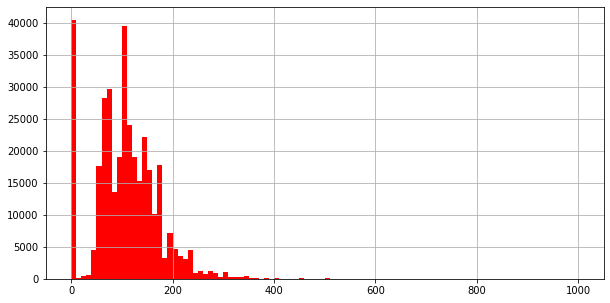

In [17]:
data['Power'].hist(figsize=(10, 5), color='red', bins=100, range=(0, 1000))

Автомобилей с мощностью двигателя более 1000 л.с. в природе крайне мало. При этом на графике видно, что значений 400+ тоже не много. Отсечем данные, в которых указанна большая, чем 400 л.с. мощность.

In [18]:
data.drop(index=data.loc[data['Power'] > 400].index, axis=0, inplace=True)

Проверим распределение данных.

<AxesSubplot:>

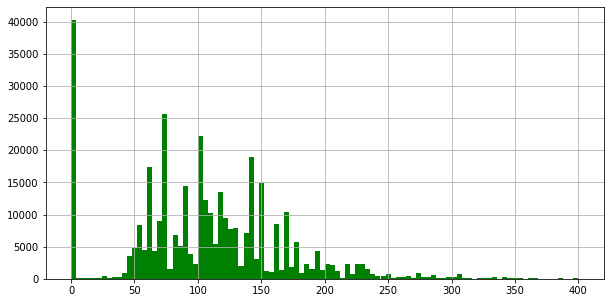

In [19]:
data['Power'].hist(figsize=(10, 5), color='green', bins=100)

Проверим распределение данных по признаку RegistrationYear

<AxesSubplot:>

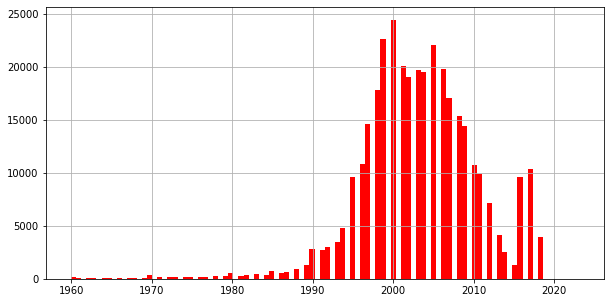

In [20]:
data['RegistrationYear'].hist(figsize=(10, 5), bins=100, range=(1960, 2023), color='red')

In [21]:
data['RegistrationYear'].describe(percentiles=[0.99])

count    353630.000000
mean       2004.223397
std          89.815770
min        1000.000000
50%        2003.000000
99%        2018.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

Основное распределение лежит в пределах от 1960 года по 2018. Оставим только эти данные, остальные удалим как аномалии.

In [22]:
data.drop(index=data.loc[(data['RegistrationYear'] < 1960) | (data['RegistrationYear'] > 2018)].index, 
          axis=0, 
          inplace=True)

<AxesSubplot:>

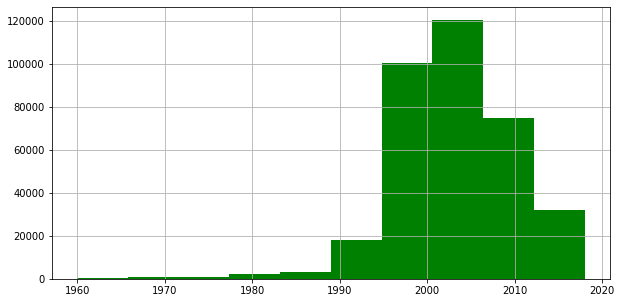

In [23]:
data['RegistrationYear'].hist(figsize=(10, 5), bins=10, color='green')

Рассмотрим признак Kilometer.

<AxesSubplot:>

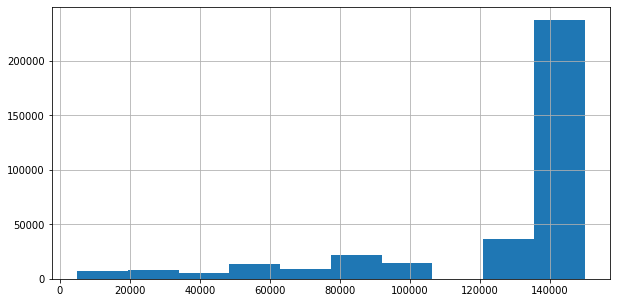

In [24]:
data['Kilometer'].hist(figsize=(10, 5), bins=10)

Распределение данных похоже на правду.

Проверим отсуствие аномалий в месяцах.

In [25]:
data['RegistrationMonth'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

В данных присутсвует месяц, обозначенный как "0". Посмотрим количество данных с таким значением признака.

In [26]:
data.loc[data['RegistrationMonth'] == 0].count()

Price                37007
VehicleType          37007
RegistrationYear     37007
Gearbox              37007
Power                37007
Model                37007
Kilometer            37007
RegistrationMonth    37007
FuelType             37007
Brand                37007
Repaired             37007
dtype: int64

Данных с нулевым месяцем около 10%, оставим их как есть.

Проверим наличие дубликатов

In [28]:
data.duplicated().sum()

29303

Удалим дубликаты.

In [29]:
data.drop_duplicates(inplace=True)

Результаты предобработки отобразим методом info().

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 353096 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              353096 non-null  int64 
 1   VehicleType        353096 non-null  object
 2   RegistrationYear   353096 non-null  int64 
 3   Gearbox            353096 non-null  object
 4   Power              353096 non-null  int64 
 5   Model              353096 non-null  object
 6   Kilometer          353096 non-null  int64 
 7   RegistrationMonth  353096 non-null  int64 
 8   FuelType           353096 non-null  object
 9   Brand              353096 non-null  object
 10  Repaired           353096 non-null  object
dtypes: int64(5), object(6)
memory usage: 32.3+ MB


In [31]:
print('Удалено', round((1 - data.shape[0] / primary_shape) * 100, 0), '% данных')

Удалено 9.0 % данных


## Обучение моделей

### Подготовка данных к обучению.

Подготовим данные к обучению. Выделим целевой признак.

In [32]:
X = data.drop('Price', axis=1)
y = data['Price']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [34]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, 
                                                      y_train, 
                                                      test_size=0.2, 
                                                      random_state=RANDOM_STATE
                                                     )

In [35]:
X_train_for_cat = X_train.copy() #сделал копию для встроенного encoding в catboost
X_valid_for_cat = X_valid.copy()

In [36]:
X_train_for_lgbm = X_train.copy() #сделал копию для встроенного encoding в LightGBM
X_valid_for_lgbm = X_valid.copy()

In [40]:
ord_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)

In [41]:
list_of_cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

In [42]:
X_train[list_of_cat_features] = ord_encoder.fit_transform(X_train[list_of_cat_features])

In [43]:
for c in list_of_cat_features:
    X_train_for_lgbm[c] = X_train_for_lgbm[c].astype('category')
    X_valid_for_lgbm[c] = X_valid_for_lgbm[c].astype('category')

### Обучение модели LightGBMRegressor.

In [ ]:
start = time.time()
lgbm = LGBMRegressor()
param_lgbm = {'max_depth' : range(10, 300, 30),
              'metric' : ['rmse'],
              'force_col_wise' : [False],
              'random_state' : [RANDOM_STATE],
              'num_leaves' : range(5, 30, 5),
              'categorical_feature' : ['auto']}
model = GridSearchCV(lgbm, param_grid=param_lgbm, cv=3)
model.fit(X_train_for_lgbm, y_train)
end = time.time()
time_lgbm = exec_time(start, end)

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param di

### Обучение случайного леса

In [ ]:
start = time.time()
rfr = RandomForestRegressor()
param_rfr = {'n_estimators'  : range(100, 300, 100),
             'n_jobs' : [-1],
             'random_state' : [RANDOM_STATE],
             'max_depth' : range(3, 6 , 3)}
model_rfr = GridSearchCV(rfr, param_grid=param_rfr, cv=3)
model_rfr.fit(X_train, y_train)
end = time.time()
time_rfr = exec_time(start, end)
model_rfr.best_params_

### Обучение CatBoostRegressor

In [ ]:
start = time.time()
cat = CatBoostRegressor()
param_cat = {'iterations' : range(500, 2000, 500),
             'depth' : range(2, 8, 2),
             'random_state' : [RANDOM_STATE],
             'cat_features' : [list_of_cat_features]
             }
model_cat = GridSearchCV(cat, param_grid=param_cat, cv=3)
model_cat.fit(X_train_for_cat, y_train)
end = time.time()
time_cat = exec_time(start, end)


## Анализ моделей

Рассчитаем затрачиваемое время у моделей с лучшими параметрами.

In [ ]:
X_valid[list_of_cat_features] = ord_encoder.transform(X_valid[list_of_cat_features])
start = time.time()
model.best_estimator_.fit(X_train_for_lgbm, y_train)
pred = model.best_estimator_.predict(X_valid_for_lgbm)
end = time.time()
time_lgbm = exec_time(start, end)


In [ ]:
start = time.time()
model_rfr.best_estimator_.fit(X_train, y_train)
pred_rfr = model_rfr.best_estimator_.predict(X_valid)
end = time.time()
time_rfr = exec_time(start, end)

In [ ]:
start = time.time()
model_cat.best_estimator_.fit(X_train_for_cat, y_train, cat_features=list_of_cat_features)
pred_cat = model_cat.predict(X_valid_for_cat)
end = time.time()
time_cat = exec_time(start, end)

Сопоставим полученные RMSE моделей и затрачиваемое время.

In [ ]:
results = {'LightGBM' : [mean_squared_error(y_valid, pred, squared=False), str(time_lgbm)],
           'RandomForestRegressor' : [mean_squared_error(y_valid, pred_rfr, squared=False), time_rfr],
           'CatBoost' : [mean_squared_error(y_valid, pred_cat, squared=False), time_cat]
           }
pd.DataFrame(data=results, index=['RMSE', 'Время'])

### Тестирование лучшей модели (LightGBM)

In [ ]:
for c in list_of_cat_features:
    X_test[c] = X_test[c].astype('category')

In [ ]:
X_test[list_of_cat_features] = ord_encoder.transform(X_test[list_of_cat_features])

pred_test = model.predict(X_test)
print('RMSE валидации - ', mean_squared_error(y_valid, pred, squared=False),
      'RMSE тестовой выборки - ', mean_squared_error(y_test, pred_test, squared=False))

### Вывод

Все исследуемые модели уложились в заданные задачей характеристики по велечине метрики. Однако на первичном обучении, и на выводимых результатах на уже выбранных гиперпараметрах наименьшее время показала модель обученная LightGBM. При этом чуть лучшее качество показал CatBoost.